# Web Scraping for Reddit & Predicting Comments

In this project, we will practice two major skills. Collecting data by scraping a website and then building a binary predictor.

As we discussed in week 2, and earlier today, there are two components to starting a data science problem: the problem statement, and acquiring the data.

For this article, your problem statement will be: _What characteristics of a post on Reddit contribute most to the overall interaction (as measured by number of comments)?_

Your method for acquiring the data will be scraping the 'hot' threads as listed on the [Reddit homepage](https://www.reddit.com/). You'll acquire _AT LEAST FOUR_ pieces of information about each thread:
1. The title of the thread
2. The subreddit that the thread corresponds to
3. The length of time it has been up on Reddit
4. The number of comments on the thread

Once you've got the data, you will build a classification model that, using Natural Language Processing and any other relevant features, predicts whether or not a given Reddit post will have above or below the _median_ number of comments.

**BONUS PROBLEMS**
1. If creating a logistic regression, GridSearch Ridge and Lasso for this model and report the best hyperparameter values.
1. Scrape the actual text of the threads using Selenium (you'll learn about this in Webscraping II).
2. Write the actual article that you're pitching and turn it into a blog post that you host on your personal website.

### Scraping Thread Info from Reddit.com

#### Set up a request (using requests) to the URL below. Use BeautifulSoup to parse the page and extract all results

In [2]:
import requests
from bs4 import BeautifulSoup
import numpy as np
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_union, make_pipeline, Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn import metrics
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

%matplotlib inline

In [158]:
url = "http://www.reddit.com/"

In [159]:
## Establishing the connection to the web page:
response = requests.get(url, headers={'User-Agent':'InternetResearchAgency'})

print(response.status_code)

# Pull the HTML string out of requests and convert it to a Python string.
html = response.text

#html

200


In [160]:
soup = BeautifulSoup(html, 'lxml')
#soup

While this has some more verbose elements removed, we can see that there is some structure to the above:
- The thread title is within an `<a>` tag with the attribute `data-event-action="title"`.
- The time since the thread was created is within a `<time>` tag with attribute `class="live-timestamp"`.
- The subreddit is within an `<a>` tag with the attribute `class="subreddit hover may-blank"`.
- The number of comments is within an `<a>` tag with the attribute data-event-action="comments"`.

## Write 4 functions to extract these items (one function for each): title, time, subreddit, and number of comments.¶
Example
```python
def extract_title_from_result(result):
    return result.find ...
```

##### - Make sure these functions are robust and can handle cases where the data/field may not be available.
>- Remember to check if a field is empty or None for attempting to call methods on it
>- Remember to use try/except if you anticipate errors.

- **Test** the functions on the results above and simple examples

In [3]:

def extract_title_from_result(soup):
    title_list = []
    for each in soup.find_all('a', {'class':'title'}):
        title_list.append((each.text))
    return title_list

#extract_title_from_result(soup)
    


In [4]:
def extract_subreddit_from_result(soup):
    subreddit_list =[]
    for each in soup.find_all('a', {'class':'subreddit'}):
        subreddit_list.append((each.text))
    return(subreddit_list)

#extract_subreddit_from_result(soup)

In [5]:
def extract_age_from_result(soup):
    age_list = []
    for each in soup.find_all('time', {'class':'live-timestamp'}):
        age_list.append((each.text))
    return(age_list)

#extract_age_from_result(soup)

In [6]:
def extract_numcom_from_result(soup):
    comment_list = []
    for each in soup.find_all('a', attrs={'class':'bylink comments may-blank'}):
        comment_list.append((each.text.split()[0]))
    return(comment_list)

#extract_numcom_from_result(soup)

Now, to scale up our scraping, we need to accumulate more results.

First, look at the source of a Reddit.com page: (https://www.reddit.com/).
Try manually changing the page by clicking the 'next' button on the bottom. Look at how the url changes.

After leaving the Reddit homepage, the URLs should look something like this:
```
https://www.reddit.com/?count=25&after=t3_787ptc
```

The URL here has two query parameters
- count is the result number that the page starts with
- after is the unique id of the last result on the _previous_ page

In order to scrape lots of pages from Reddit, we'll have to change these parameters every time we make a new request so that we're not just scraping the same page over and over again. Incrementing the count by 25 every time will be easy, but the bizarre code after `after` is a bit trickier.

To start off, let's look at a block of HTML from a Reddit page to see how we might solve this problem:
```html
<div class=" thing id-t3_788tye odd gilded link " data-author="LordSneaux" data-author-fullname="t2_j3pty" data-comments-count="1548" data-context="listing" data-domain="v.redd.it" data-fullname="t3_788tye" data-kind="video" data-num-crossposts="0" data-permalink="/r/funny/comments/788tye/not_all_heroes_wear_capes/" data-rank="25" data-score="51468" data-subreddit="funny" data-subreddit-fullname="t5_2qh33" data-timestamp="1508775581000" data-type="link" data-url="https://v.redd.it/ush0rh2tultz" data-whitelist-status="all_ads" id="thing_t3_788tye" onclick="click_thing(this)">
      <p class="parent">
      </p>
      <span class="rank">
       25
      </span>
      <div class="midcol unvoted">
       <div aria-label="upvote" class="arrow up login-required access-required" data-event-action="upvote" role="button" tabindex="0">
       </div>
       <div class="score dislikes" title="53288">
        53.3k
       </div>
       <div class="score unvoted" title="53289">
        53.3k
       </div>
       <div class="score likes" title="53290">
        53.3k
       </div>
       <div aria-label="downvote" class="arrow down login-required access-required" data-event-action="downvote" role="button" tabindex="0">
       </div>
      </div>
```

Notice that within the `div` tag there is an attribute called `id` and it is set to `"thing_t3_788tye"`. By finding the last ID on your scraped page, you can tell your _next_ request where to start (pass everything after "thing_").

For more info on this, you can take a look at the [Reddit API docs](https://github.com/reddit/reddit/wiki/JSON)

## Write one more function that finds the last `id` on the page, and stores it.

In [7]:
def last_id(soup):
    all_div = soup.find_all('div', attrs={'data-type': 'link'})
    return all_div[-1]['data-fullname']

#last_id(soup)

## (Optional) Collect more information

While we only require you to collect four features, there may be other info that you can find on the results page that might be useful. Feel free to write more functions so that you have more interesting and useful data.

In [ ]:
## YOUR CODE HERE

## Now, let's put it all together.

Use the functions you wrote above to parse out the 4 fields - title, time, subreddit, and number of comments. Create a dataframe from the results with those 4 columns.

In [8]:
import time

In [24]:
url_template = "http://www.reddit.com/?count={}&after={}"
max_results = 2000 # Set this to a high-value (5000) to generate more results. 
# Crawling more results, will also take much longer. 
# First test your code on a small number of results and then expand.
soup_list = []

id_list = [0]

for start in range(0, max_results, 25):
    res = requests.get("http://www.reddit.com/?count="+str(start)+"&after="+str(id_list[-1]), 
                       headers={'User-Agent':'InternetResearchAgency'})
    #print(f'(http://www.reddit.com/?count=+{str(start)}+&after=+{str(id_list[-1])})')
    print(start)
    #print(id_list[-1])
    soup = BeautifulSoup(res.content, 'lxml')
    soup_list.append(soup)
    id_list.append(last_id(soup))
    if start%500 == 0:
        time.sleep(90)

0
25
50
75
100
125
150
175
200
225
250
275
300
325
350
375
400
425
450
475
500
525
550
575
600
625
650
675
700
725
750
775
800
825
850
875
900
925
950
975
1000
1025
1050
1075
1100
1125
1150
1175
1200
1225
1250
1275
1300
1325
1350
1375
1400
1425
1450
1475
1500
1525
1550
1575
1600
1625
1650
1675
1700
1725
1750
1775
1800
1825
1850
1875
1900
1925
1950
1975


In [52]:
len(soup_list)

80

In [53]:
# Extracting the titles from each page and appending it to a list
title_list=[]

for each in soup_list:
    title_list.append(extract_title_from_result(each))

#title_list

In [54]:
# Extracting the number of comments from each page and appending it to a list
comment_list = []

for each in soup_list:
    comment_list.append(extract_numcom_from_result(each))
    
    
#comment_list

In [55]:
# Extracting the subreddits from each page and appending it to a list
subreddit_list=[]

for each in soup_list:
    subreddit_list.append(extract_subreddit_from_result(each))
    
#subreddit_list

In [56]:
# Extracting the age of the posts on each page and appending them to a list
age_list=[]

for each in soup_list:
    age_list.append(extract_age_from_result(each))

#age_list

In [57]:
len(title_list), len(age_list), len(comment_list), len(subreddit_list)

(80, 80, 80, 80)

In [58]:
# Taking a list of lists and converting it to a flat out list

title_list = [item for sublist in title_list for item in sublist]

age_list = [item for sublist in age_list for item in sublist]

comment_list = [item for sublist in comment_list for item in sublist]

subreddit_list = [item for sublist in subreddit_list for item in sublist]

In [59]:
len(title_list), len(age_list), len(comment_list), len(subreddit_list)

(1980, 1980, 1977, 1980)

In [375]:
# Creating a dataframe from our 4 lists
reddit_df = pd.DataFrame({'title':title_list, 
              'age':age_list,
              'num_com':comment_list, 
              'subreddit':subreddit_list})
             

In [ ]:
reddit_df.head()

In [376]:
reddit_df.shape

(2500, 4)

### Save your results as a CSV
You may do this regularly while scraping data as well, so that if your scraper stops of your computer crashes, you don't lose all your data.

In [337]:
# Export to csv
# reddit_df.to_csv(path_or_buf='reddit_data2.csv')

## Predicting comments using Random Forests + Another Classifier

#### Load in the the data of scraped results

In [53]:
reddit_df = pd.read_csv('./reddit_data.csv')

In [54]:
# converting the number of comments to integer
reddit_df['num_com'] = reddit_df['num_com'].astype(int)

In [55]:
reddit_df.drop('Unnamed: 0',axis=1, inplace=True)

In [56]:
reddit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 4 columns):
age          2500 non-null object
num_com      2500 non-null int64
subreddit    2500 non-null object
title        2500 non-null object
dtypes: int64(1), object(3)
memory usage: 78.2+ KB


In [57]:
reddit_df.title.value_counts()

CGI of 1920s New York in The Great Gatsby                                                                                                                                                                                                                                                                   11
Anime_irl                                                                                                                                                                                                                                                                                                   10
"Don't pre-order games on eShop" - Norwegian Consumer Council formally asks Nintendo to explain their breach of the EU Consumer Rights Directive. Nintendos online store is the only gaming store that doesn't allow consumers to cancel a pre-order, which is illegal.                                     10
This handicap toilet in a 4 star hotel.                                                    

In [58]:
# dropping duplicate title posts unless they are in different subreddits
reddit_df.drop_duplicates(subset=['title', 'subreddit'], inplace=True)

In [59]:
reddit_df.shape

(626, 4)

In [60]:
# Looking for a difference in unit in time
reddit_df[reddit_df['age'].str.contains("minute")]

,age,num_com,subreddit,title
2254,38 minutes ago,50,r/PoliticalHumor,When you see a cringey right-wing meme and dec...


In [61]:
# Rounding up from 38 minutes to one hour
reddit_df['age'][2254] = '1 hour ago'

/Users/reef/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [62]:
# dropping the string segment "Hour/Hours ago" from our age column
reddit_df['age'] = reddit_df['age'].str.rstrip(" hour%s% ago")

In [63]:
# converting age value to ingeters
reddit_df['age'] = reddit_df['age'].astype(int)

In [64]:
reddit_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 626 entries, 0 to 2349
Data columns (total 4 columns):
age          626 non-null int64
num_com      626 non-null int64
subreddit    626 non-null object
title        626 non-null object
dtypes: int64(2), object(2)
memory usage: 44.5+ KB


#### We want to predict a binary variable - whether the number of comments was low or high. Compute the median number of comments and create a new binary variable that is true when the number of comments is high (above the median)

We could also perform Linear Regression (or any regression) to predict the number of comments here. Instead, we are going to convert this into a _binary_ classification problem, by predicting two classes, HIGH vs LOW number of comments.

While performing regression may be better, performing classification may help remove some of the noise of the extremely popular threads. We don't _have_ to choose the `median` as the splitting point - we could also split on the 75th percentile or any other reasonable breaking point.

In fact, the ideal scenario may be to predict many levels of comment numbers. 

In [65]:
## median of number of comments
np.median(reddit_df['num_com'])

62.0

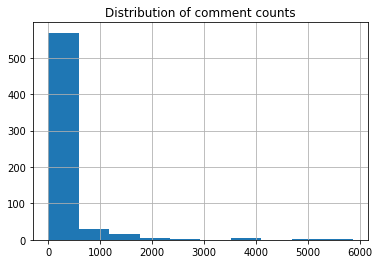

In [141]:
# distribution of comments is heavily right-skewed
reddit_df['num_com'].hist();
plt.title("Distribution of comment counts");

In [67]:
# binary conversion of "does this post have high comments?"
y = []
for each in reddit_df['num_com']:
    if each <= 62:
        y.append(0)
    else:
        y.append(1)
        
reddit_df['high_com'] = y

In [68]:
reddit_df.head()

,age,num_com,subreddit,title,high_com
0,3,461,r/LifeProTips,LPT: Keep a separate master resume with ALL pr...,1
1,3,345,r/web_design,Animated login avatar,1
2,4,1331,r/woahdude,First image ever taken of the Hydrogen Atom,1
3,4,700,r/funny,Not a method actor,1
4,5,386,r/MovieDetails,"At the end of Ferris Bueller’s Day Off, he app...",1


#### Thought experiment: What is the baseline accuracy for this model?

In [69]:
## YOUR CODE HERE
reddit_df['high_com'].value_counts()

0    315
1    311
Name: high_com, dtype: int64

In [70]:
baseline_accuracy = reddit_df['high_com'].value_counts()[0]/len(reddit_df['high_com'])
baseline_accuracy

0.5031948881789138

#### Create a Random Forest model to predict High/Low number of comments using Sklearn. Start by ONLY using the subreddit as a feature. 

In [71]:
## Setting our X and y
y = reddit_df['high_com']
X = pd.get_dummies(reddit_df['subreddit'])

In [72]:
# creating our train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [73]:
# Random Forest Model

rfc_reddit = RandomForestClassifier()
rfc_reddit.fit(X_train,y_train)

score_rfc_reddit = rfc_reddit.score(X_test,y_test)

# using crossvalidation to check how accurate the model is
cv_reddit = cross_val_score(rfc_reddit, X_test, y_test, cv=5, verbose=1).mean()

print('Baseline:', baseline_accuracy)
print('Random Forrest Score:', score_rfc_reddit)
print('Cross Validation Score:', cv_reddit)

Baseline: 0.5031948881789138
Random Forrest Score: 0.6063829787234043
Cross Validation Score: 0.5267461793777583


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished


In [74]:
# performing a Gridsearch for RFC

rfc_params={
    'n_estimators':[5,10,15,20],
    'criterion':['gini','entropy'],
    'max_depth':[1,2,3,4,None]}

rfc_gridsearch = GridSearchCV(RandomForestClassifier(), rfc_params, verbose=1, cv=5)
rfc_gridsearch.fit(X_train,y_train)

print('GridSearch score:',rfc_gridsearch.best_score_)
print('Best Parameters:', rfc_gridsearch.best_params_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
GridSearch score: 0.5981735159817352
Best Parameters: {'criterion': 'entropy', 'max_depth': None, 'n_estimators': 10}


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    5.7s finished


In [75]:
# getting our predicted y values
y_preds = rfc_reddit.predict(X_test)

In [76]:
subred_coef_df = pd.DataFrame(list(zip(rfc_reddit.feature_importances_, reddit_df['subreddit'])),
             columns=['feature_importance','subreddit']).sort_values(by='feature_importance', ascending=False)

subred_coef_df.head(10)

,feature_importance,subreddit
20,0.024499,r/facepalm
407,0.019854,r/webcomics
333,0.014714,r/memes
58,0.012521,r/Whatcouldgowrong
339,0.010271,r/NotMyJob
303,0.009864,r/eagles
139,0.009190,r/2meirl4meirl
416,0.009111,r/lego
79,0.008995,r/The_Mueller
188,0.008889,r/dadjokes


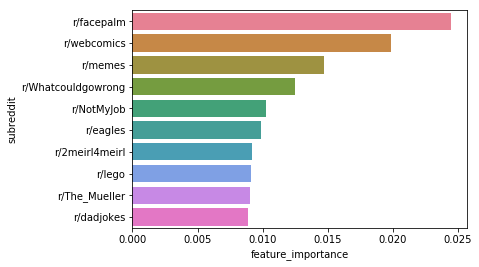

In [138]:
sns.barplot(subred_coef_df['feature_importance'],subred_coef_df['subreddit'].head(10), palette='husl');

In [78]:
rfc_df_confusion = pd.crosstab(y_test, y_preds, rownames=['Actual'], colnames=['Predicted'], margins=True)
rfc_df_confusion

Predicted,0,1,All
Actual,,,
0,88,4,92
1,70,26,96
All,158,30,188


In [96]:
print('Accuracy - Overall, how often is the classifier correct?')
print(round((88+26)/188,2))

Accuracy - Overall, how often is the classifier correct?
0.61


In [80]:
print('Misclassification Rate - Overall, how often is it wrong?')
print(round((4+70)/188,2))

Misclassification Rate - Overall, how often is it wrong?
0.39


In [86]:
print('True Positive Rate - When it\'s actually yes, how often does it predict yes?')
print(round(26/96,2))

True Positive Rate - When it's actually yes, how often does it predict yes?
0.27


In [83]:
print('False Positive Rate - When it\'s actually no, how often does it predict yes?')
print(round(4/96,2))

False Positive Rate - When it's actually no, how often does it predict yes?
0.04


In [84]:
print('Specificity - When it\'s actually no, how often does it predict no?')
print(round(88/92,2))

Specificity - When it's actually no, how often does it predict no?
0.96


In [85]:
print('Precision - When it predicts yes, how often is it correct?')
print(round(26/30,2))

Precision - When it predicts yes, how often is it correct?
0.87


## RFC - Using Subreddit to Predict High Comment Posts.
    
The RFC model was more accurate than our Baseline by roughly 10%. The model leaned heavily toward negative predictions resulting in a high false negative value. That being said, it had a faily high value for Specificity and Precision.

/rFacepalm was the most influential feature in the model with coefficient of 0.0245. 

#### Create a few new variables in your dataframe to represent interesting features of a thread title.
- For example, create a feature that represents whether 'cat' is in the title or whether 'funny' is in the title. 
- Then build a new Random Forest with these features. Do they add any value?
- After creating these variables, use count-vectorizer to create features based on the words in the thread titles.
- Build a new random forest model with subreddit and these new features included.

In [88]:
# creating a new feature if the title contains the word cat
cat_bool = reddit_df.title.str.contains('cat')
cat=[]
for each in cat_bool:
    if each == True:
        cat.append(1)
    else:
        cat.append(0)
        
reddit_df['has_cat'] = cat

In [91]:
# Setting our X and y and train/test split
y = reddit_df['high_com']
X = reddit_df['has_cat'].reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3)

/Users/reef/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [92]:
cat_rfc = RandomForestClassifier()
cat_rfc.fit(X_train,y_train)

score_cat = cat_rfc.score(X_test,y_test)

# using crossvalidation to check how accurate the model is
cv_cat = cross_val_score(cat_rfc, X_test, y_test, cv=5, verbose=1).mean()

print('Baseline:', baseline_accuracy)
print('Random Forrest Score:', score_cat)
print('Cross Validation Score:', cv_cat)

Baseline: 0.5031948881789138
Random Forrest Score: 0.44680851063829785
Cross Validation Score: 0.5691505270452639


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished


In [93]:
y_preds = cat_rfc.predict(X_test)

#### Use cross-validation in scikit-learn to evaluate the model above. 
- Evaluate the accuracy of the model, as well as any other metrics you feel are appropriate. 

In [94]:
cat_confusion = pd.crosstab(y_test, y_preds, rownames=['Actual'], colnames=['Predicted'], margins=True)
cat_confusion

Predicted,0,1,All
Actual,,,
0,3,104,107
1,0,81,81
All,3,185,188


In [98]:
print('Accuracy - Overall, how often is the classifier correct?')
print(round((3+81)/188,2))

Accuracy - Overall, how often is the classifier correct?
0.45


In [99]:
print('Misclassification Rate - Overall, how often is it wrong?')
print(round((0+104)/188,2))

Misclassification Rate - Overall, how often is it wrong?
0.55


In [100]:
print('True Positive Rate - When it\'s actually yes, how often does it predict yes?')
print(round(81/81,2))

True Positive Rate - When it's actually yes, how often does it predict yes?
1.0


In [101]:
print('False Positive Rate - When it\'s actually no, how often does it predict yes?')
print(round(104/107,2))

False Positive Rate - When it's actually no, how often does it predict yes?
0.97


In [102]:
print('Specificity - When it\'s actually no, how often does it predict no?')
print(round(3/107,2))

Specificity - When it's actually no, how often does it predict no?
0.03


In [103]:
print('Precision - When it predicts yes, how often is it correct?')
print(round(81/185,2))

Precision - When it predicts yes, how often is it correct?
0.44


#### RFC - Predicting high comment posts using "cat" in the title as a variable.

This model was 5% less accurate than our baseline model. This model pretty much predicted every post to have a high comments. This resulted in a 100% true positive rate and a 97% false positive rate. Having cat in the title was not a good variable to use in a random forest model.

### Repeat the model-building process with a non-tree-based method.

In [107]:
# GridSearching the best parameters for KNeighbors model
knn_parameters = {
    'n_neighbors':[1,3,5,9,15,21],
    'weights':['uniform','distance'],
    'p':[1,2]
}

knn_gridsearcher = GridSearchCV(KNeighborsClassifier(), knn_parameters, verbose=1, cv=5, n_jobs=4)
knn_gridsearcher.fit(X_train, y_train)

print(knn_gridsearcher.best_score_)
print(knn_gridsearcher.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
0.5159817351598174
{'n_neighbors': 9, 'p': 1, 'weights': 'distance'}


[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed:    0.2s finished


In [109]:
# Building a KNN model using the best params we found through grid searching
cat_knn = KNeighborsClassifier(n_neighbors=9, p=1, weights='distance')
cat_knn.fit(X_train, y_train)
score_knn = cat_knn.score(X_test, y_test)

print('Baseline:', baseline_accuracy)
print('KNN Score:', score_knn)

Baseline: 0.5031948881789138
KNN Score: 0.44680851063829785


In [110]:
y_preds = cat_knn.predict(X_test)

In [111]:
cat_confusion = pd.crosstab(y_test, y_preds, rownames=['Actual'], colnames=['Predicted'], margins=True)
cat_confusion

Predicted,0,1,All
Actual,,,
0,3,104,107
1,0,81,81
All,3,185,188


In [112]:
print('Accuracy - Overall, how often is the classifier correct?')
print(round((3+81)/188,2))

Accuracy - Overall, how often is the classifier correct?
0.45


In [114]:
print('Misclassification Rate - Overall, how often is it wrong?')
print(round((0+104)/188,2))

Misclassification Rate - Overall, how often is it wrong?
0.55


In [115]:
print('True Positive Rate - When it\'s actually yes, how often does it predict yes?')
print(round(81/81,2))

True Positive Rate - When it's actually yes, how often does it predict yes?
1.0


In [116]:
print('False Positive Rate - When it\'s actually no, how often does it predict yes?')
print(round(104/107,2))

False Positive Rate - When it's actually no, how often does it predict yes?
0.97


In [117]:
print('Specificity - When it\'s actually no, how often does it predict no?')
print(round(3/107,2))

Specificity - When it's actually no, how often does it predict no?
0.03


In [118]:
print('Precision - When it predicts yes, how often is it correct?')
print(round(81/185,2))

Precision - When it predicts yes, how often is it correct?
0.44


#### KNN - Predicting high comment posts using "cat" in the title as a variable.

This model had the exact same outcome as the random forest classifier. 

### Use Count Vectorizer from scikit-learn to create features from the thread titles. 
- Examine using count or binary features in the model
- Re-evaluate your models using these. Does this improve the model performance? 
- What text features are the most valuable? 

In [119]:
## Count Vectorizing the words in reddit post titles
X = reddit_df['title']
y = reddit_df['high_com']

X_train, X_test, y_train, y_test = train_test_split(X,y)

cv = CountVectorizer(stop_words='english')
cv.fit(X_train)

Xs_train = pd.DataFrame(cv.transform(X_train).todense(), columns=cv.get_feature_names())
Xs_test = pd.DataFrame(cv.transform(X_test).todense(), columns=cv.get_feature_names())

In [120]:
# Fitting a RFC on the CV titles
rfc = RandomForestClassifier()
rfc.fit(Xs_train, y_train)
score = rfc.score(Xs_test, y_test)
cvs = cross_val_score(rfc, Xs_test, y_test, cv=5).mean()

print('Baseline:', baseline_accuracy)
print('Random Forrest Score:', score)
print('Cross Validation Score:', cvs)

Baseline: 0.5031948881789138
Random Forrest Score: 0.5605095541401274
Cross Validation Score: 0.4657258064516129


In [121]:
y_preds = rfc.predict(Xs_test)

In [139]:

title_coef_df = pd.DataFrame(list(zip(rfc.feature_importances_, Xs_test)),
             columns=['feature_importance','title_word']).sort_values(by='feature_importance', ascending=False)

title_coef_df.head(10)

,feature_importance,title_word
1159,0.011246,money
871,0.009570,hmmm
1906,0.009367,way
1031,0.008968,like
1227,0.006283,oc
131,0.005784,anime_irl
1789,0.005711,time
213,0.005637,believe
1661,0.005546,status
202,0.005040,beard


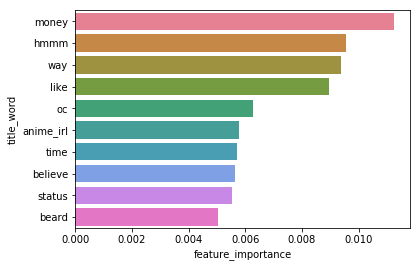

In [140]:
sns.barplot(title_coef_df['feature_importance'],title_coef_df['title_word'].head(10), palette='husl');

In [126]:
cv_confusion = pd.crosstab(y_test, y_preds, rownames=['Actual'], colnames=['Predicted'], margins=True)
cv_confusion

Predicted,0,1,All
Actual,,,
0,69,9,78
1,60,19,79
All,129,28,157


In [127]:
print('Accuracy - Overall, how often is the classifier correct?')
print(round((69+19)/157,2))

Accuracy - Overall, how often is the classifier correct?
0.56


In [128]:
print('Misclassification Rate - Overall, how often is it wrong?')
print(round((0+60)/157,2))

Misclassification Rate - Overall, how often is it wrong?
0.38


In [129]:
print('True Positive Rate - When it\'s actually yes, how often does it predict yes?')
print(round(19/79,2))

True Positive Rate - When it's actually yes, how often does it predict yes?
0.24


In [131]:
print('False Positive Rate - When it\'s actually no, how often does it predict yes?')
print(round(9/78,2))

False Positive Rate - When it's actually no, how often does it predict yes?
0.12


In [132]:
print('Specificity - When it\'s actually no, how often does it predict no?')
print(round(69/78,2))

Specificity - When it's actually no, how often does it predict no?
0.88


In [133]:
print('Precision - When it predicts yes, how often is it correct?')
print(round(19/79,2))

Precision - When it predicts yes, how often is it correct?
0.24


#### CV RFC - Using words in the post titles as variables to predict high coment posts.

This model was 6% more accurate than our baseline. It leaned very heavily toward negative predictions resulting in high false negatives. 

The term "money" had the most feature importance at 0.0112.

# Executive Summary
---
Put your executive summary in a Markdown cell below.

Reddit calls itself "The Front Page of the Internet", and there has never been as more appropriate slogan. The website is a mix of news, social commentary, cool links, and pictures of cats. It boasts over 250 million unique users and 542 million monthly users. These users drive posts into the spot light using "upvotes" or make them disappear by "downvoting" them. It's clear to see why this is a wonderful platform to expose your idea, campaign, or website.

But understanding the way posts become popular can be a bit tricky. The website is made up of numerous sub-pages called "sub-reddits". There are 853,824 currently and that number is ever growing. This is merely one in many variables that need to be accounted for in order to make sure your product is out there for all to see.

Looking at comments on a post give us a clear indication of how popular a post is. Simply put, the more comments the post has, the more popular/controversial the post is. Luckily the website makes it incredibly easy to access the information we need by simply scraping the html elements through a python script. Using the aggregated data, we can build classification models and predict what objects influence a post having a high-comment threshold.

Our baseline accuracy was 50.3%. Using a random forest classifier model and setting our independent variable as the subreddit, we were able to produce a model that was 10.3% more accurate. Through this model, we were able to see that /rFacepalm was the most important feature in the model, with a coefficient of 0.0245. 

### BONUS
Refer to the README for the bonus parts

In [ ]:
## YOUR CODE HERE